In [72]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [73]:
from fastai import *
from fastai.tabular import * 
from fastai.callbacks import *

In [74]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

In [236]:
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

In [76]:
from sklearn.manifold import TSNE
from sklearn.metrics import average_precision_score


In [233]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from sklearn.metrics import fbeta_score, make_scorer

In [312]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier

In [78]:
df = pd.read_csv('creditcard.csv.zip')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [79]:
columns_start=df.columns

In [80]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


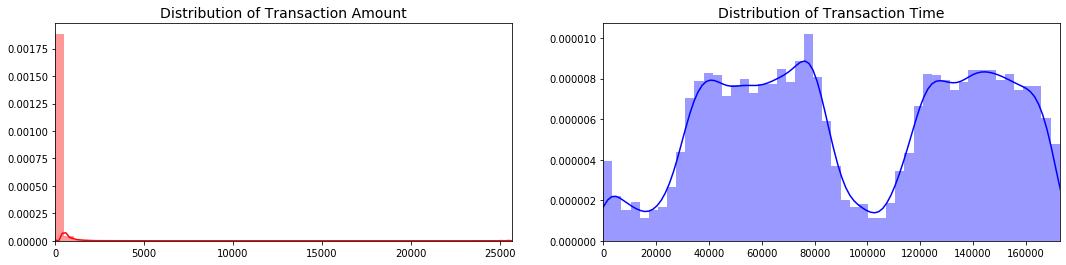

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

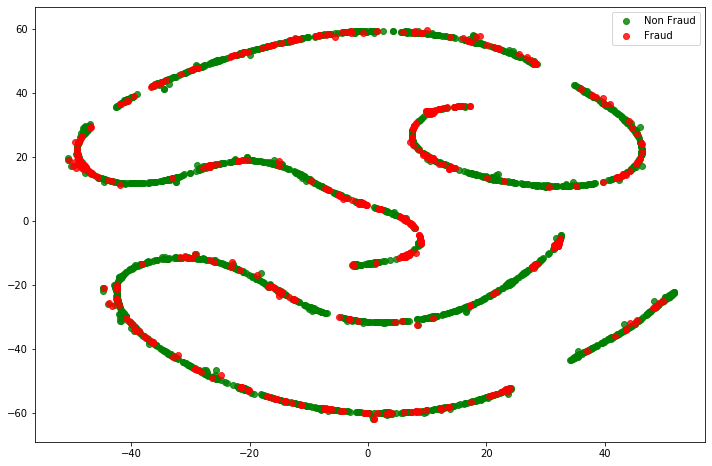

In [82]:
non_fraud_tsne = df[df['Class'] == 0].sample(2000)
fraud_tsne = df[df['Class'] == 1]

df_tsne = non_fraud_tsne.append(fraud_tsne).sample(frac=1).reset_index(drop=True)
X = df_tsne.drop(['Class'], axis = 1).values
Y = df_tsne["Class"].values

def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0, n_jobs=-1)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")

In [83]:
y=df.pop('Class')

### Цю частину виконувати у випадку, якщо є необхідність знов формувати виборки

In [12]:
X_train, X_test, y_train, y_test=train_test_split(df, y, test_size=0.2, random_state=42, shuffle=True, stratify=y )

In [13]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((227845, 30), (56962, 30), (227845,), (56962,))

In [15]:
y_test.value_counts(normalize=True)

0    0.99828
1    0.00172
Name: Class, dtype: float64

In [16]:
y_train.value_counts(normalize=True)

0    0.998271
1    0.001729
Name: Class, dtype: float64

In [17]:
small_neg_skew=[]
neg_skew=[]
small_pos_skew=[]
pos_skew=[]
for i in X_train.columns:
    print(i, X_train[i].skew())
    if  -2<=X_train[i].skew()<0:
        small_neg_skew.append(i)
    elif X_train[i].skew()<-2:
        neg_skew.append(i)
    elif 0<=X_train[i].skew()<2:
        small_pos_skew.append(i)
    elif X_train[i].skew()>=2:
        pos_skew.append(i)

Time -0.03739402082331843
V1 -3.306333873286609
V2 -4.779483646244919
V3 -2.2479615417179355
V4 0.6875737807063625
V5 -2.7868509783867927
V6 1.9373806731632068
V7 3.152665384428463
V8 -8.639484559009192
V9 0.5418694483718128
V10 1.1326875961553382
V11 0.35410221990782464
V12 -2.286653939807935
V13 0.06481947526790258
V14 -1.969112453878546
V15 -0.3084191901737468
V16 -1.077909118330574
V17 -3.7333773489216813
V18 -0.254947666566547
V19 0.10613250442806194
V20 -1.9604915939642753
V21 3.490182908369094
V22 -0.21917148964939037
V23 -6.2585575695702
V24 -0.5498542447990878
V25 -0.43629209814008046
V26 0.5749797150912774
V27 -0.8902091274566919
V28 9.97840867182521
Amount 18.193943169847156


In [18]:
len(small_neg_skew), len(neg_skew), len(small_pos_skew), len(pos_skew)

(10, 8, 8, 4)

In [19]:
#small_neg_skew_pipe=Pipeline([
#    ('imputer', SimpleImputer(strategy='mean')),
#    #('square', FunctionTransformer(np.square)),
#    ('scaler', StandardScaler())
#])

#neg_skew_pipe=Pipeline([
#    ('imputer', SimpleImputer(strategy='mean')),
#    ('square', FunctionTransformer(np.square)),
#    ('scaler', RobustScaler())
#])

#small_pos_skew_pipe=Pipeline([
#    ('imputer', SimpleImputer(strategy='mean')),
#    #('log1p', FunctionTransformer(np.log1p)),
#    ('scaler', StandardScaler())
#])

#pos_skew_pipe=Pipeline([
#    ('imputer', SimpleImputer(strategy='mean')),
#    ('log1p', FunctionTransformer(np.log1p)),
#    ('scaler', RobustScaler())
#])

In [20]:
#transformers=[('small_neg_skew', small_neg_skew_pipe, small_neg_skew),
#             ('neg_skew',neg_skew_pipe,neg_skew),
#             ('small_pos_skew',small_pos_skew_pipe,small_pos_skew),
#             ('pos_skew',pos_skew_pipe, pos_skew)]

In [21]:
time_pipe=Pipeline([
    #('imputer', SimpleImputer(strategy='mean')),
    #('log1p', FunctionTransformer(np.log1p)),
    ('scaler', StandardScaler())
])

amount_pipe=Pipeline([
    #('imputer', SimpleImputer(strategy='mean')),
    ('log1p', FunctionTransformer(np.log1p)),
    ('scaler', RobustScaler())
])

In [22]:
transformers=[('time', time_pipe, ['Time'] ),
             ('amount', amount_pipe,['Amount'])]

In [23]:
ct=ColumnTransformer(transformers=transformers, remainder='passthrough')

In [24]:
X_train_tr=ct.fit_transform(X_train)
X_test_tr=ct.transform(X_test)

In [25]:
X_train_tr_df=pd.DataFrame(np.concatenate((X_train_tr, y_train.values.reshape(-1,1)), axis=1), columns=columns_start)

In [148]:
X_test_tr_df=pd.DataFrame(np.concatenate((X_test_tr, y_test.values.reshape(-1,1)), axis=1), columns=columns_start)

In [149]:
X_train_tr_df.shape, X_test_tr_df.shape

((227845, 31), (56962, 31))

In [153]:
X_train_tr_df.to_csv('df_train.csv', index=False)
X_test_tr_df.to_csv('df_test.csv', index=False)

## Зчитуємо трейн та тест, якщо пропустили кусок кода вище

In [84]:
X_train_tr_df=pd.read_csv('df_train.csv')
X_test_tr_df= pd.read_csv('df_test.csv')

In [85]:
X_train_tr_df.shape, X_test_tr_df.shape

((227845, 31), (56962, 31))

In [86]:
X_train_tr_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.411588,-0.411696,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,1.139880,...,-0.134435,0.076197,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248,0.0
1,0.623141,-0.709232,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,0.674782,...,-0.227279,0.038628,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002,0.0
2,-1.130680,0.824159,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-5.037523,...,1.280856,-2.798352,0.109526,-0.436530,-0.932803,0.826684,0.913773,0.038049,0.185340,0.0
3,0.794699,-0.475897,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,...,-0.490642,-0.139670,0.077013,0.208310,-0.538236,-0.278032,-0.162068,0.018045,-0.063005,0.0
4,-0.748102,0.539125,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.147490,0.504347,-0.113817,...,-0.275297,-0.243245,-0.173298,-0.006692,-1.362383,-0.292234,-0.144622,-0.032580,-0.064194,0.0


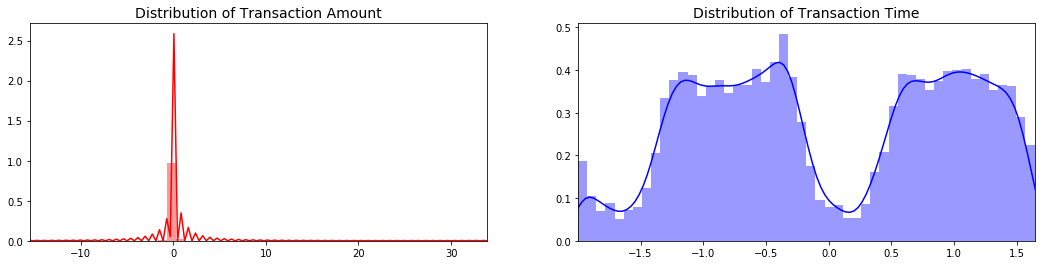

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = X_train_tr_df['Amount'].values
time_val = X_train_tr_df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

In [88]:
X_train_tr_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.278450e+05,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,...,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,-1.386676e-16,0.007111,0.000795,-0.000481,-0.000383,-0.000020,0.000175,-0.001171,0.000077,-0.000434,...,-0.000999,0.000370,0.000303,0.000050,-0.000277,-0.000655,0.000126,-0.000070,0.000154,0.001729
std,1.000002e+00,0.670482,1.958926,1.649092,1.515292,1.415867,1.379569,1.331218,1.238431,1.191482,...,0.770806,0.734963,0.725735,0.627419,0.605322,0.521236,0.481939,0.404934,0.326939,0.041548
min,-1.998073e+00,-1.269503,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,...,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000
25%,-8.561495e-01,-0.503017,-0.919893,-0.598761,-0.891767,-0.847111,-0.692100,-0.768603,-0.553481,-0.207839,...,-0.211651,-0.228250,-0.542056,-0.161932,-0.354843,-0.316907,-0.326491,-0.070740,-0.052931,0.000000
50%,-2.122647e-01,0.000000,0.018692,0.064746,0.179859,-0.021361,-0.054757,-0.274156,0.040420,0.023219,...,-0.062606,-0.029280,0.006599,-0.010983,0.040778,0.016081,-0.051623,0.001463,0.011221,0.000000
75%,9.366285e-01,0.496983,1.315616,0.803876,1.026457,0.742281,0.611259,0.397501,0.570530,0.327824,...,0.132702,0.186365,0.528282,0.147589,0.438966,0.349880,0.240835,0.091180,0.078118,0.000000
max,1.640549e+00,2.841638,2.451888,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,...,39.420904,27.202839,10.503090,22.528412,4.584549,6.070850,3.517346,31.612198,33.847808,1.000000


In [89]:
X_train_tr_df.shape

(227845, 31)

In [90]:
X_autoenc=X_train_tr_df[X_train_tr_df['Class']==0].copy()
X_autoenc.drop('Class', inplace=True, axis=1)
X_autoenc.shape

(227451, 30)

In [91]:
max_value = X_autoenc.max().max()
min_value = X_autoenc.min().min()
print(max_value, min_value)

120.589493945238 -113.74330671114599


In [92]:
src = FloatList(X_autoenc)
src = src.split_by_rand_pct()
src = src.label_from_lists(src.train, src.valid)
src = src.add_test(FloatList(X_autoenc))
src = src.databunch(bs=1024)

In [93]:
x,y = next(iter(src.train_dl))
x.shape, y.shape

(torch.Size([1024, 30]), torch.Size([1024, 30]))

In [94]:
x[0], y[0]

(tensor([ 0.5445, -0.1077, -1.9481,  1.2088,  0.9081, -0.5146,  1.5524,  0.2542,
          1.8579, -1.4422,  0.9940,  1.5643, -0.6462,  0.0431,  1.0719, -1.3400,
          0.6129, -1.3005, -0.5558, -0.6382,  1.6039,  0.0432, -0.4351, -0.4839,
         -0.3288,  0.1984,  0.5971, -0.4698, -1.9657, -0.5839], device='cuda:0'),
 tensor([ 0.5445, -0.1077, -1.9481,  1.2088,  0.9081, -0.5146,  1.5524,  0.2542,
          1.8579, -1.4422,  0.9940,  1.5643, -0.6462,  0.0431,  1.0719, -1.3400,
          0.6129, -1.3005, -0.5558, -0.6382,  1.6039,  0.0432, -0.4351, -0.4839,
         -0.3288,  0.1984,  0.5971, -0.4698, -1.9657, -0.5839], device='cuda:0'))

In [95]:
# autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            *bn_drop_lin(30, 128, bn=False, actn=nn.LeakyReLU()),
            *bn_drop_lin(128, 64, actn=nn.LeakyReLU()),
        )
        self.decoder = nn.Sequential(
            *bn_drop_lin(64, 128, actn=nn.LeakyReLU()),
            *bn_drop_lin(128, 30, actn=SigmoidRange(min_value, max_value))
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [96]:
model = Autoencoder().cuda()

In [97]:
model(x).shape

torch.Size([1024, 30])

In [98]:
learn = Learner(src, model, loss_func=F.mse_loss)

In [99]:
learn.summary()


Autoencoder
Layer (type)         Output Shape         Param #    Trainable 
Linear               [128]                3,968      True      
______________________________________________________________________
LeakyReLU            [128]                0          False     
______________________________________________________________________
BatchNorm1d          [128]                256        True      
______________________________________________________________________
Linear               [64]                 8,256      True      
______________________________________________________________________
LeakyReLU            [64]                 0          False     
______________________________________________________________________
BatchNorm1d          [64]                 128        True      
______________________________________________________________________
Linear               [128]                8,320      True      
__________________________________________________

## Виконувати, якщо використовуєте навчену модель

In [100]:
learn.load(Path('seconf_08_12_19_21_00'))

Learner(data=DataBunch;

Train: LabelList (181961 items)
x: FloatList
[ 1.411587 -0.411696  1.946747 -0.752526 -1.355129 -0.66163   1.502822  4.024933 -1.479661  1.13988   1.406819
 -0.157403 -0.113729  0.510277  0.061258 -0.066555  1.328702  0.352514 -0.76567   0.141938 -0.451365 -0.134435
  0.076197  0.297537  0.307915  0.69098  -0.350316 -0.388907  0.077641 -0.032248],[-0.748102  0.539125 -0.448747 -1.01144   0.115903 -3.454854  0.715771 -0.14749   0.504347 -0.113817 -0.044782
 -0.558955 -0.251076 -0.054708 -0.782698  0.134659 -0.483007 -2.0961   -0.399525  1.597589 -0.082746 -0.275297
 -0.243245 -0.173298 -0.006692 -1.362383 -0.292234 -0.144622 -0.03258  -0.064194],[-0.325998  0.689548  1.320449 -1.560991 -0.154324 -1.806184 -0.831334  0.87782  -1.212515  0.24602  -1.747897
  1.518364 -0.2196   -1.160047 -0.241156 -0.036872  0.554341  0.280024 -0.114839  0.669845  0.313595 -0.123905
 -0.346511 -0.941239 -0.104322 -1.790279  0.184198 -0.299018  0.025862  0.016056],[ 0.358381 -0.8968

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


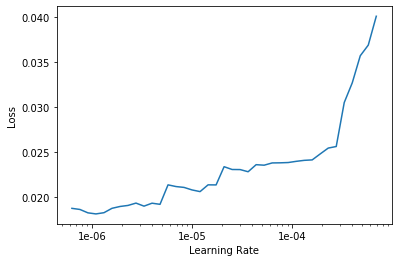

In [57]:
learn.lr_find()
learn.recorder.plot()

In [61]:
learn.fit_one_cycle(10, 0.000001)

epoch,train_loss,valid_loss,time
0,0.024246,0.011016,00:03
1,0.023071,0.010093,00:03
2,0.024939,0.010153,00:03
3,0.022661,0.010348,00:03
4,0.024470,0.010654,00:03
5,0.023249,0.010113,00:03
6,0.023944,0.010961,00:03
7,0.024345,0.011262,00:03
8,0.023875,0.010402,00:03
9,0.023342,0.010122,00:03


epoch	train_loss	valid_loss	time
0	0.189000	0.180156	00:04
1	0.287018	0.467215	00:04
2	0.292077	0.306176	00:03
3	0.237288	0.203427	00:04
4	0.149369	0.134622	00:04
5	0.088536	0.066543	00:04
6	0.080653	0.046932	00:04
7	0.045803	0.037981	00:04
8	0.031222	0.014614	00:04
9	0.020877	0.009416	00:04

In [62]:
#learn.save(Path('seconf_08_12_19_21_00'))

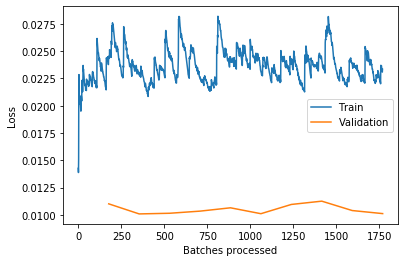

In [63]:
learn.recorder.plot_losses()

In [31]:
learn.model.encoder


Sequential(
  (0): Linear(in_features=30, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
)

In [101]:
bottleneck = learn.model.encoder[4]


In [102]:
hook = hook_output(bottleneck)


In [103]:
learn.data.test_dl.dl.sampler


In [104]:
embeding_not_fraud = []
tensor_out_not_fraud=[]
for x, _ in learn.data.test_dl:
    tensor_out_not_fraud.append(learn.model(x))
    embeding_not_fraud.append(hook.stored)

In [105]:
torch.cat(embeding_not_fraud).shape, len(src.test_ds), torch.cat(tensor_out_not_fraud).shape



(torch.Size([227451, 64]), 227451, torch.Size([227451, 30]))

In [106]:
embeding_not_fraud = torch.cat(embeding_not_fraud)
tensor_out_not_fraud=torch.cat(tensor_out_not_fraud)

In [107]:
embeding_not_fraud = embeding_not_fraud.cpu().numpy()
embeding_not_fraud.shape

(227451, 64)

In [108]:
torch.nn.functional.mse_loss(tensor_out_not_fraud, torch.Tensor(X_autoenc.values).cuda())

tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward>)

## Создадим для трейна выборку ембедінгов фрауда

In [109]:
X_autoenc_fraud=X_train_tr_df[X_train_tr_df['Class']==1].copy()
X_autoenc_fraud.drop('Class', inplace=True, axis=1)
X_autoenc_fraud.shape

(394, 30)

In [110]:
src_fraud = FloatList(X_autoenc_fraud)
src_fraud = src_fraud.split_by_rand_pct()
src_fraud = src_fraud.label_from_lists(src_fraud.train, src_fraud.valid)
src_fraud = src_fraud.add_test(FloatList(X_autoenc_fraud))
src_fraud = src_fraud.databunch(bs=1028)

You can deactivate this warning by passing `no_check=True`.


/home/serhiy/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/basic_data.py:247: UserWarning: Your training dataloader is empty, you have only 316 items in your training set.
                 Your batch size is 1028, you should lower it.
  Your batch size is {self.train_dl.batch_size}, you should lower it.""")


In [111]:
embeding_fraud = []
tensor_out_fraud=[]
for x, _ in src_fraud.test_dl:
    tensor_out_fraud.append(learn.model(x))
    embeding_fraud.append(hook.stored)

In [112]:
torch.cat(embeding_fraud).shape, len(src_fraud.test_ds), torch.cat(tensor_out_fraud).shape


(torch.Size([394, 64]), 394, torch.Size([394, 30]))

In [113]:
embeding_fraud = torch.cat(embeding_fraud)
tensor_out_fraud=torch.cat(tensor_out_fraud)

In [114]:
embeding_fraud = embeding_fraud.cpu().detach().numpy()
embeding_fraud.shape

(394, 64)

In [115]:
torch.nn.functional.mse_loss(tensor_out_fraud, torch.Tensor(X_autoenc_fraud.values).cuda())

tensor(1.1147, device='cuda:0', grad_fn=<MseLossBackward>)

In [116]:
from sklearn.metrics import mean_squared_error

In [117]:
tensor_init=X_autoenc_fraud.values
tensor_after_nn=tensor_out_fraud.cpu().detach().numpy()

In [118]:
mean_squared_error(tensor_init, tensor_after_nn)

1.1147401703104978

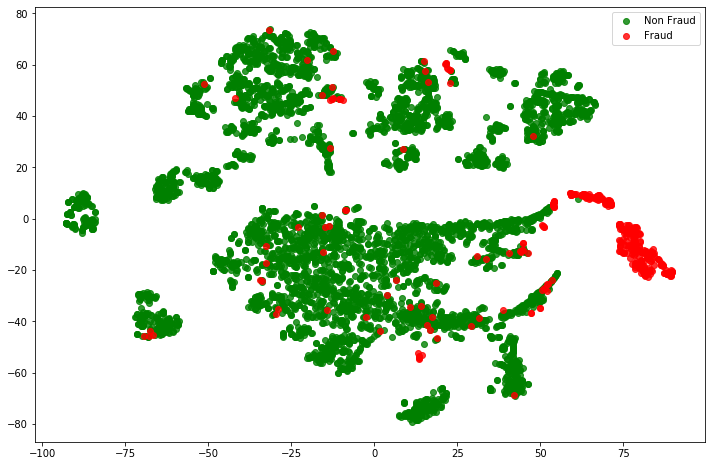

In [120]:
idx = np.random.randint(200000, size=5000)

embeding_not_fraud_5000=embeding_not_fraud[idx]
rep_x = np.append(embeding_not_fraud_5000, embeding_fraud, axis = 0)
y_n = np.zeros(embeding_not_fraud_5000.shape[0])
y_f = np.ones(embeding_fraud.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")

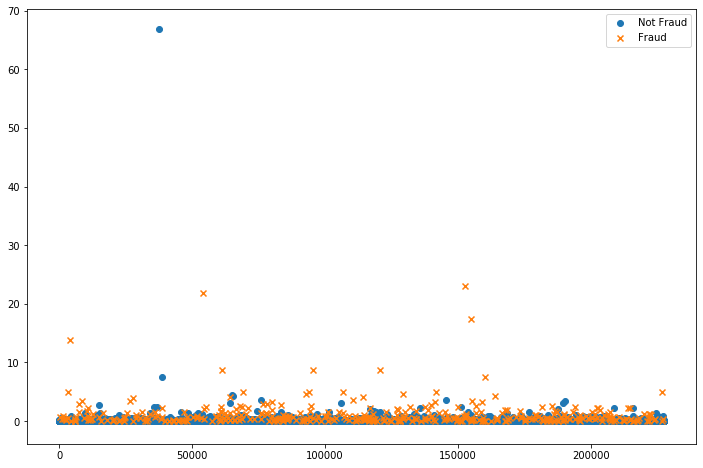

In [121]:
plt.figure(figsize=(12,8))

y_error_not_fraud=mean_squared_error(X_autoenc.values.transpose(), tensor_out_not_fraud.cpu().detach().numpy().transpose(), multioutput='raw_values')
plt.scatter(np.arange(y_error_not_fraud.shape[0]), y_error_not_fraud , marker='o',label= "Not Fraud" )

y_error_fraud=mean_squared_error(X_autoenc_fraud.values.transpose(), tensor_out_fraud.cpu().detach().numpy().transpose(), multioutput='raw_values')
plt.scatter(np.random.randint(y_error_not_fraud.shape[0], size=y_error_fraud.shape[0])  , y_error_fraud, marker='x',label= "Fraud")

plt.legend()
plt.show()

In [122]:
y_error_not_fraud.shape, y_error_fraud.shape

((227451,), (394,))

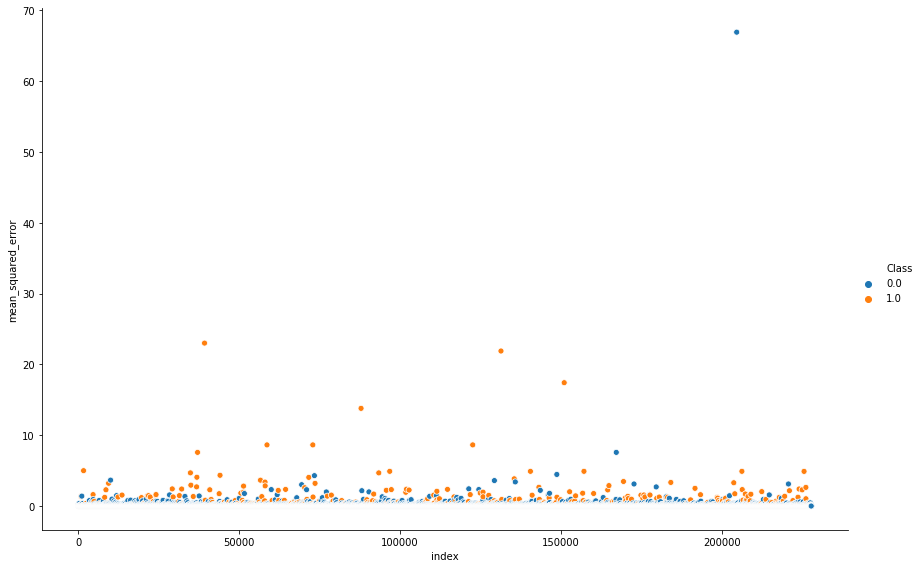

In [123]:
#y_error_train=np.vstack((y_error_not_fraud.reshape(-1,1),  y_error_fraud.reshape(-1,1)))
y_error_train=np.append (y_error_not_fraud,  y_error_fraud)

df_error_train=pd.DataFrame(columns=['index','mean_squared_error','Class'])
df_error_train['mean_squared_error']=y_error_train

y_n = np.zeros(y_error_not_fraud.shape[0])
y_f = np.ones(y_error_fraud.shape[0])

df_error_train['Class']=np.append(y_n, y_f)
df_error_train = df_error_train.sample(frac=1).reset_index(drop=True)

df_error_train['index']=df_error_train.index


sns.relplot(x='index', y='mean_squared_error',  hue='Class',  data=df_error_train, height=8, aspect=1.5);

In [124]:
df_error_train.groupby('Class').agg({'mean_squared_error':np.mean})

,mean_squared_error
Class,
0.0,0.010224
1.0,1.114740


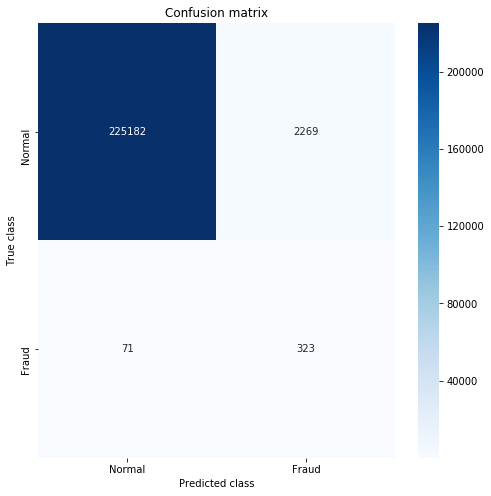

In [125]:
threshold = 0.1
LABELS = ["Normal", "Fraud"]

y_pred = [1 if e > threshold else 0 for e in df_error_train['mean_squared_error']]
conf_matrix = confusion_matrix(df_error_train['Class'], y_pred)
plt.figure(figsize=(8, 8))
ax=sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", 
            cmap=plt.cm.get_cmap('Blues'))

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [126]:
# Compute Precision-Recall and plot curve
precision, recall, thresholds = precision_recall_curve(df_error_train['Class'], df_error_train['mean_squared_error'])
area = auc(recall, precision)
print ("Area Under PR Curve(AP): %0.2f" % area)  

print ('AP', average_precision_score(df_error_train['Class'], df_error_train['mean_squared_error'], average='weighted'))
print ('AP', average_precision_score(df_error_train['Class'], df_error_train['mean_squared_error'], average='macro'))
print ('AP', average_precision_score(df_error_train['Class'], df_error_train['mean_squared_error'], average='micro'))
print ('AP', average_precision_score(df_error_train['Class'], df_error_train['mean_squared_error'], average='samples'))

Area Under PR Curve(AP): 0.47
AP 0.4684556248633637
AP 0.4684556248633637
AP 0.4684556248633637
AP 0.4684556248633637


In [192]:
f1_score(df_error_train['Class'],y_pred)

0.2163429336905559

In [158]:
col_embeding=[f'f{i}' for i in range(embeding_fraud.shape[1])]

In [148]:
embeding_train_df=pd.DataFrame(data=np.append(embeding_not_fraud, embeding_fraud, axis=0), columns=col_embeding)

In [150]:
embeding_train_df.shape

(227845, 64)

In [151]:
embeding_train_df['MSE']=df_error_train['mean_squared_error']
embeding_train_df['Class']=df_error_train['Class']

In [152]:
embeding_train_df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f56,f57,f58,f59,f60,f61,f62,f63,MSE,Class
0,0.470267,-0.007547,-0.008186,0.667139,0.741596,0.209797,-0.004673,1.179345,0.467975,1.195856,...,0.342453,0.088854,1.044089,0.560527,0.165839,1.196718,2.736533,0.746575,0.001322,0.0
1,0.481249,-0.007564,-0.006155,0.847517,0.859390,0.139803,-0.003128,1.129077,0.625011,0.871136,...,0.298284,0.286741,0.822661,0.250925,0.241708,1.641507,2.460240,0.160010,0.005557,0.0
2,0.976875,-0.014802,-0.021348,2.264407,1.704301,1.467916,-0.014085,1.121711,2.321834,2.472465,...,-0.004253,0.031729,0.919030,3.242069,0.913460,1.719325,2.510049,1.027969,0.001738,0.0
3,-0.011277,0.789308,2.063975,-0.009506,0.278693,-0.009129,1.565504,-0.020443,-0.005363,-0.014171,...,2.206115,1.182074,-0.008137,0.401811,-0.014886,-0.011441,-0.010691,-0.016319,0.026359,0.0
4,1.114845,-0.018412,-0.016159,1.571529,0.954398,-0.000522,-0.015090,0.821102,1.275781,1.693203,...,-0.007659,0.276677,1.245352,0.902864,0.737733,2.085627,1.755158,1.780655,0.006185,0.0


In [154]:
embeding_train_df.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f56,f57,f58,f59,f60,f61,f62,f63,MSE,Class
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,...,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,1.082539,0.469379,0.644702,1.057826,0.974605,0.535420,0.597371,1.123857,0.875483,1.231074,...,0.598837,0.565410,1.042683,0.998692,1.136712,1.110116,1.294839,1.158308,0.012134,0.001729
std,1.614622,0.645165,0.859795,1.524557,1.383770,1.483700,0.790691,1.645871,1.466654,1.666519,...,0.815930,1.098880,1.624387,1.404627,1.661149,1.408062,1.951372,1.805535,0.179763,0.041548
min,-0.020036,-0.653281,-0.432829,-0.014241,-0.003676,-0.016638,-0.351129,-0.023400,-0.012932,-0.019472,...,-0.232894,-0.211602,-0.018115,-0.003035,-0.020168,-0.024419,-0.035947,-0.021462,0.000351,0.000000
25%,-0.007824,-0.015200,-0.018437,-0.006246,0.561943,-0.005387,-0.014079,-0.009251,-0.004544,-0.010776,...,-0.010674,-0.000305,-0.006299,0.543748,-0.010285,-0.008078,-0.009638,-0.008968,0.002293,0.000000
50%,0.804444,-0.007795,-0.011802,0.945339,0.743888,0.204664,-0.008614,0.767707,0.629255,1.026060,...,-0.004293,0.387373,0.778713,0.716660,0.932671,1.055003,0.978797,0.900938,0.004155,0.000000
75%,1.550753,1.086955,1.464655,1.477941,0.986990,0.513435,1.367857,1.656672,1.140762,1.801666,...,1.165313,0.828897,1.438952,0.961883,1.585153,1.630671,1.877044,1.643724,0.008273,0.000000
max,58.240753,2.313150,3.083548,49.139778,99.205688,28.758627,2.732510,76.354477,67.045311,61.613464,...,22.752081,83.070328,73.926529,76.883347,61.658409,57.949108,90.515587,84.744629,66.919333,1.000000


In [159]:
col_embeding.append('MSE')

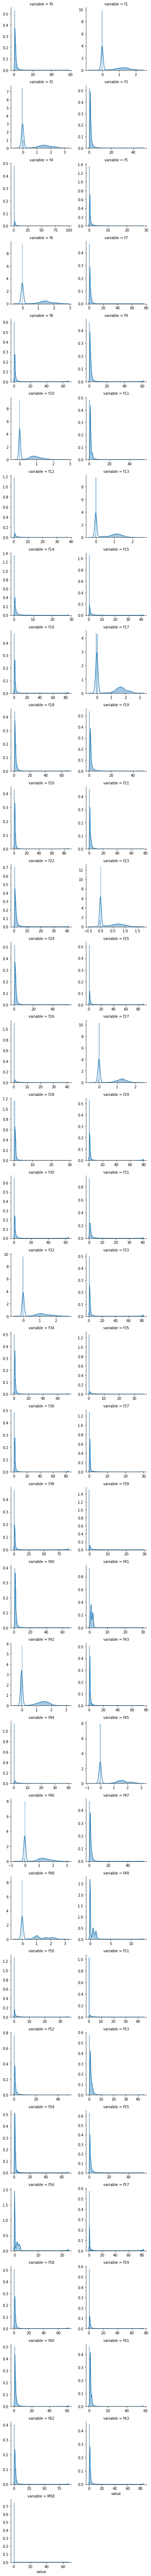

In [161]:
f = pd.melt(embeding_train_df, value_vars=col_embeding)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

In [163]:
st_scaler=StandardScaler()

In [167]:
transformers=[('standardscaler', st_scaler, col_embeding )]

In [168]:
ct=ColumnTransformer(transformers=transformers, remainder='passthrough')

In [171]:
embeding_train_tr=ct.fit_transform(embeding_train_df)

In [172]:
embeding_train_df_tr=pd.DataFrame(data=embeding_train_tr, columns=embeding_train_df.columns)

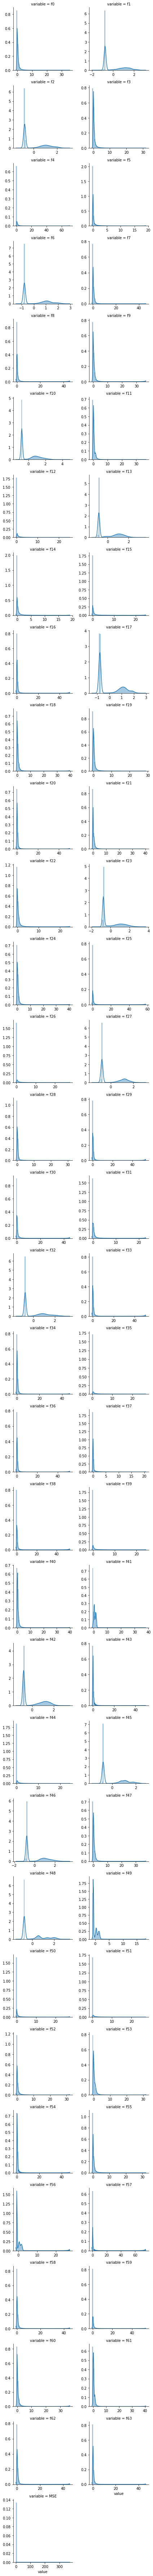

In [173]:
f = pd.melt(embeding_train_df_tr, value_vars=col_embeding)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

In [ ]:
X=embeding_train_df_tr.iloc[:,:-1]
y_true=embeding_train_df_tr.iloc[:,-1].apply(int)

In [293]:
ccw=compute_class_weight(class_weight='balanced', classes=[0,1], y=embeding_train_df_tr['Class'])

In [294]:
ccw

array([  0.500866, 289.143401])

In [300]:
train_x, val_x, train_y, val_y = train_test_split(X, y_true, test_size=0.25, random_state=17)
clf = LogisticRegression(solver="lbfgs",class_weight=ccw, n_jobs=-1).fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))



Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56880
           1       0.68      0.32      0.43        82

    accuracy                           1.00     56962
   macro avg       0.84      0.66      0.72     56962
weighted avg       1.00      1.00      1.00     56962



In [301]:
lg=LogisticRegression(solver="lbfgs", class_weight=ccw, n_jobs=-1)

In [302]:
skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [303]:
cross_val_score(lg, X=X, y=y_true,
               cv=skf, scoring='precision', n_jobs=-1)


array([0.789474, 0.866667, 0.68    , 0.653846, 0.777778])

In [308]:
ftwo_scorer = make_scorer(fbeta_score, beta=5)
grid = GridSearchCV(lg, param_grid={'C': [0.1,1,2,5]}, scoring=ftwo_scorer, cv=skf, n_jobs=-1, verbose=1 )

In [309]:
grid.fit(X,y_true)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   21.4s remaining:   21.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   25.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0,
                                          class_weight=array([  0.500866, 289.143401]),
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1, param_grid={'C': [0.1, 1, 2, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(fbeta_score, beta=5), verbose=1)

In [310]:
print ("")
print ("Classification Report: ")
print (classification_report(y_true, grid.best_estimator_.predict(X)))


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.76      0.20      0.31       394

    accuracy                           1.00    227845
   macro avg       0.88      0.60      0.66    227845
weighted avg       1.00      1.00      1.00    227845



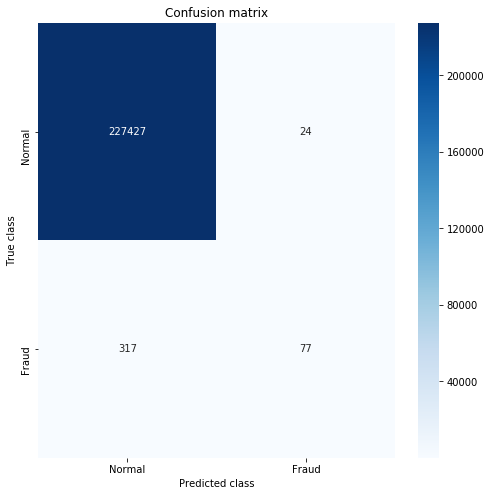

In [311]:
LABELS = ["Normal", "Fraud"]

grid.best_params_
y_pred=grid.best_estimator_.predict(X)


conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 8))
ax=sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", 
            cmap=plt.cm.get_cmap('Blues'))

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [313]:
rf=RandomForestClassifier( n_jobs=-1, random_state=17)

In [318]:
param={'n_estimators': [100,200,500], 'max_depth':[10,20,30], 'class_weight':["balanced", "balanced_subsample"] }

ftwo_scorer = make_scorer(fbeta_score, beta=0.5)
grid = GridSearchCV(rf, param_grid=param, scoring=ftwo_scorer, cv=skf, n_jobs=-1, verbose=1 )

In [319]:
grid.fit(X,y_true)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 66.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min..._leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=Fal

In [322]:
grid.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=17, verbose=0, warm_start=False)

In [323]:
grid.best_params_

{'class_weight': 'balanced_subsample', 'max_depth': 30, 'n_estimators': 200}

In [324]:
grid.best_score_

0.3030782242033586

In [320]:
print ("")
print ("Classification Report: ")
print (classification_report(y_true, grid.best_estimator_.predict(X)))


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.72      1.00      0.84       394

    accuracy                           1.00    227845
   macro avg       0.86      1.00      0.92    227845
weighted avg       1.00      1.00      1.00    227845



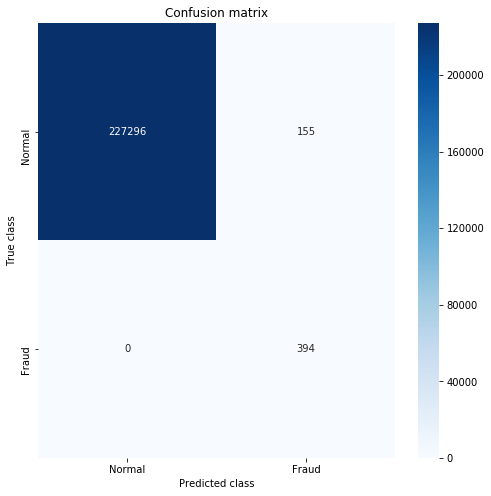

In [321]:
LABELS = ["Normal", "Fraud"]

grid.best_params_
y_pred=grid.best_estimator_.predict(X)


conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 8))
ax=sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", 
            cmap=plt.cm.get_cmap('Blues'))

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## Проверим тест

In [90]:
src_test = FloatList(X_test_tr)
src_test = src_test.split_by_rand_pct()
src_test = src_test.label_from_lists(src_test.train, src_test.valid)
src_test = src_test.add_test(FloatList(X_test_tr))
src_test = src_test.databunch(bs=1028)

In [91]:
embeding_test = []
tensor_out_test=[]
for x, _ in src_test.test_dl:
    tensor_out_test.append(learn.model(x))
    embeding_test.append(hook.stored)

In [92]:
torch.cat(embeding_test).shape, len(src_test.test_ds), torch.cat(tensor_out_test).shape


(torch.Size([56962, 64]), 56962, torch.Size([56962, 30]))

In [93]:
embeding_test = torch.cat(embeding_test)
tensor_out_test=torch.cat(tensor_out_test)

In [94]:
embeding_test = embeding_test.cpu().detach().numpy()
tensor_out_test = tensor_out_test.cpu().detach().numpy()


In [95]:
X_test_tr.shape

(56962, 30)

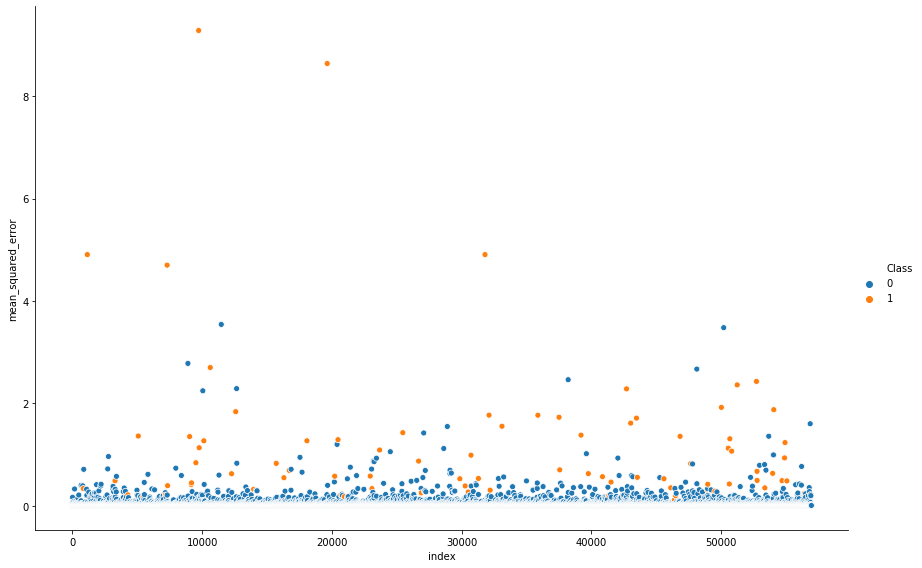

In [96]:
y_error_test=mean_squared_error(X_test_tr.transpose(), tensor_out_test.transpose(), multioutput='raw_values')

df_error_test=pd.DataFrame(columns=['index','mean_squared_error','Class'])
df_error_test['mean_squared_error']=y_error_test
df_error_test['Class']=y_test
df_error_test['index']=df_error_test.index


sns.relplot(x='index', y='mean_squared_error',  hue='Class',  data=df_error_test, height=8, aspect=1.5);



In [97]:
df_error_test.groupby('Class').agg({'mean_squared_error':np.mean})

,mean_squared_error
Class,
0,0.010255
1,1.013566


In [122]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
#%matplotlib inline


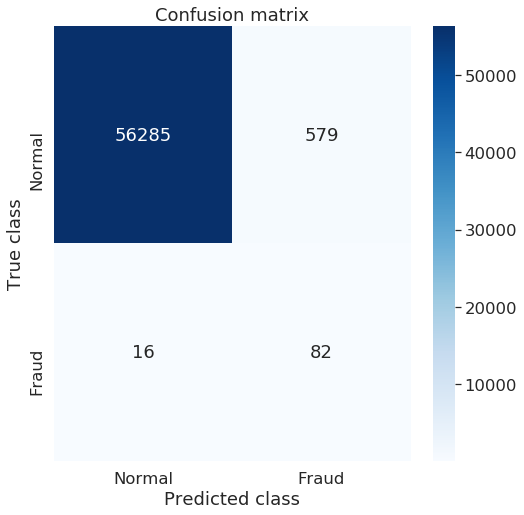

In [124]:
threshold = 0.1
LABELS = ["Normal", "Fraud"]

y_pred = [1 if e > threshold else 0 for e in df_error_test['mean_squared_error']]
conf_matrix = confusion_matrix(df_error_test['Class'], y_pred)
plt.figure(figsize=(8, 8))
ax=sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", 
            cmap=plt.cm.get_cmap('Blues'))

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

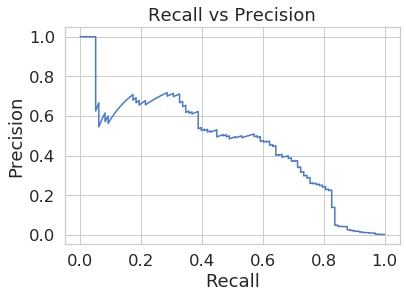

In [146]:
threshold = 0.1
y_pred = [1 if e > threshold else 0 for e in df_error_test['mean_squared_error']]

precision, recall, th = precision_recall_curve(df_error_test['Class'], df_error_test['mean_squared_error'])
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

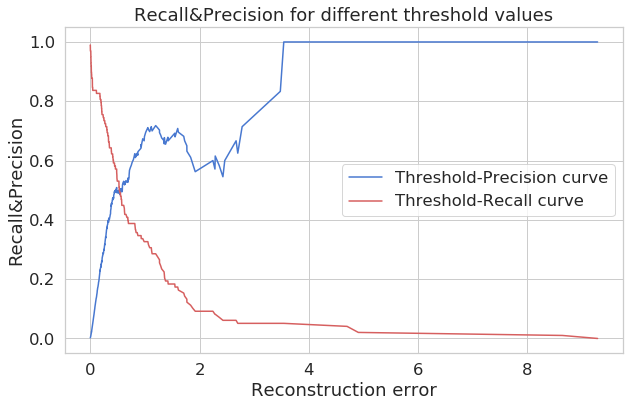

In [141]:
plt.figure(figsize=(10,6))

plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
#plt.title('Precision for different threshold values')
#plt.xlabel('Threshold')
#plt.ylabel('Precision')

plt.plot(th, recall[1:], 'r', label='Threshold-Recall curve')
plt.title('Recall&Precision for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall&Precision')
plt.legend()
plt.show()

In [142]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(df_error_test['Class'], df_error_test['mean_squared_error'])

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.47


In [162]:
# Compute Precision-Recall and plot curve
precision, recall, thresholds = precision_recall_curve(df_error_test['Class'], df_error_test['mean_squared_error'])
area = auc(recall, precision)
print ("Area Under PR Curve(AP): %0.2f" % area)  

print ('AP', average_precision_score(df_error_test['Class'], df_error_test['mean_squared_error'], average='weighted'))
print ('AP', average_precision_score(df_error_test['Class'], df_error_test['mean_squared_error'], average='macro'))
print ('AP', average_precision_score(df_error_test['Class'], df_error_test['mean_squared_error'], average='micro'))
print ('AP', average_precision_score(df_error_test['Class'], df_error_test['mean_squared_error'], average='samples'))

Area Under PR Curve(AP): 0.46
AP 0.46543004783423997
AP 0.46543004783423997
AP 0.46543004783423997
AP 0.46543004783423997
